In [105]:
import pandas as pd
import psycopg2
from tqdm import tqdm
import os

# Visualization library
import matplotlib.pyplot as plt
import seaborn as sns

## Export data from Database

In [29]:
# Credentials
database="sales_data_2019"
user='postgres'
password='xxxxx'
host='xxxxx'
port= 'xxxxx'

# Connect to database
conn = psycopg2.connect(
    database="sales_data_2019",
    user='postgres',
    password='chan.chano123099',
    host='127.0.0.1',
    port= '5000'
)
cur = conn.cursor()

# get all the table names from db
query = """
    select table_name from information_schema.tables where table_schema='public'
"""

cur.execute(query)
files = [file[0] for file in cur.fetchall()]


#export table from db to a folder
for my_file in files:
    sql_statement = f"""COPY {my_file} TO STDOUT WITH CSV HEADER"""
    with open(f'./from_db/{my_file}.csv', 'wb') as file_name:
        cur.copy_expert(sql=sql_statement, file=file_name)

print("All data was successfully transfered!")

cur.close()
conn.close()

All data was successfully transfered!


## Add all tables into 1 Data Frame

In [2]:
files = [file for file in os.listdir('./from_db')]

df = pd.DataFrame()

for file in tqdm(files, total=len(files)):
    if file.endswith('.csv'):
        data = pd.read_csv('./from_db/'+file)
        df = pd.concat([df, data], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 20.97it/s]


In [4]:
df

,order_id,product,quantity_ordered,price_each,order_date,purchase_address
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001"
1,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215"
2,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
3,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
4,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001"
...,...,...,...,...,...,...
185681,259353,AAA Batteries (4-pack),3,2.99,2019-09-17 20:56:00,"840 Highland St, Los Angeles, CA 90001"
185682,259354,iPhone,1,700.00,2019-09-01 16:00:00,"216 Dogwood St, San Francisco, CA 94016"
185683,259355,iPhone,1,700.00,2019-09-23 07:39:00,"220 12th St, San Francisco, CA 94016"
185684,259356,34in Ultrawide Monitor,1,379.99,2019-09-19 17:30:00,"511 Forest St, San Francisco, CA 94016"


In [45]:
print("Info: ", df.info())
print("|---------------------------------------|")
print("Data types:\n",df.dtypes)
print("|---------------------------------------|")
print("Null counts:\n",df.isna().sum())
print("|---------------------------------------|")
print("Duplicated values: ",df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185686 entries, 0 to 185685
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          185686 non-null  int64  
 1   product           185686 non-null  object 
 2   quantity_ordered  185686 non-null  int64  
 3   price_each        185686 non-null  float64
 4   order_date        185686 non-null  object 
 5   purchase_address  185686 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 8.5+ MB
Info:  None
|---------------------------------------|
Data types:
 order_id              int64
product              object
quantity_ordered      int64
price_each          float64
order_date           object
purchase_address     object
dtype: object
|---------------------------------------|
Null counts:
 order_id            0
product             0
quantity_ordered    0
price_each          0
order_date          0
purchase_address    0
dtype: 

## EDA

#### Data Inspection
- Our data sets are composed by 2 numerical data types 1 datetime, then objects. 
- Since this data is processed before importing to database resulting in no null and duplicate values

#### Summary statistics:
- I will analyze the total sales and revenue for each month
- I will need to create 2 columns:

In [3]:
# Sales column
df['sales'] = df['quantity_ordered']*df['price_each']

# Month and Year columns
df['order_date'] = pd.to_datetime(df['order_date'])

df['month'] = df['order_date'].dt.month_name()
df['year'] = df['order_date'].dt.year

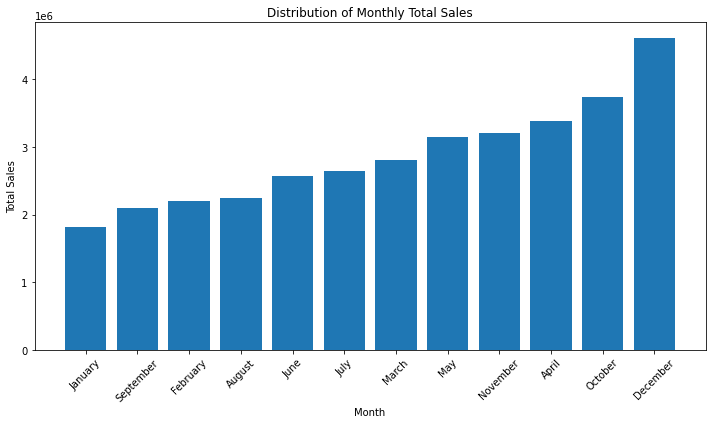

In [76]:
# Group by month and calculate the total sales for each month
monthly_total_sale = pd.DataFrame(df.groupby(['month'])['sales'].sum().sort_values().reset_index(name='sales'))

plt.figure(figsize=(10, 6))
plt.bar(monthly_total_sale['month'], monthly_total_sale['sales'])
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Distribution of Monthly Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()

### December has the highest sales, probably because of the christmas season

In [64]:
df.describe()

,order_id,quantity_ordered,price_each,order_date,sales
count,185686.000000,185686.000000,185686.000000,185686,185686.000000
mean,230411.376227,1.124544,184.519255,2019-07-18 21:32:06.298051840,185.611936
min,141234.000000,1.000000,2.990000,2019-01-01 03:07:00,2.990000
25%,185833.250000,1.000000,11.950000,2019-04-16 20:55:15,11.950000
50%,230354.500000,1.000000,14.950000,2019-07-17 20:11:00,14.950000
75%,275028.750000,1.000000,150.000000,2019-10-26 08:00:00,150.000000
max,319670.000000,9.000000,1700.000000,2020-01-01 05:13:00,3400.000000
std,51511.717183,0.443069,332.843838,NaN,333.032118


- we will only anlayse the 2019 data sales.

In [7]:
data = df[df['year'] != '2020']

# Descriptive analysis

### Identifying outliers

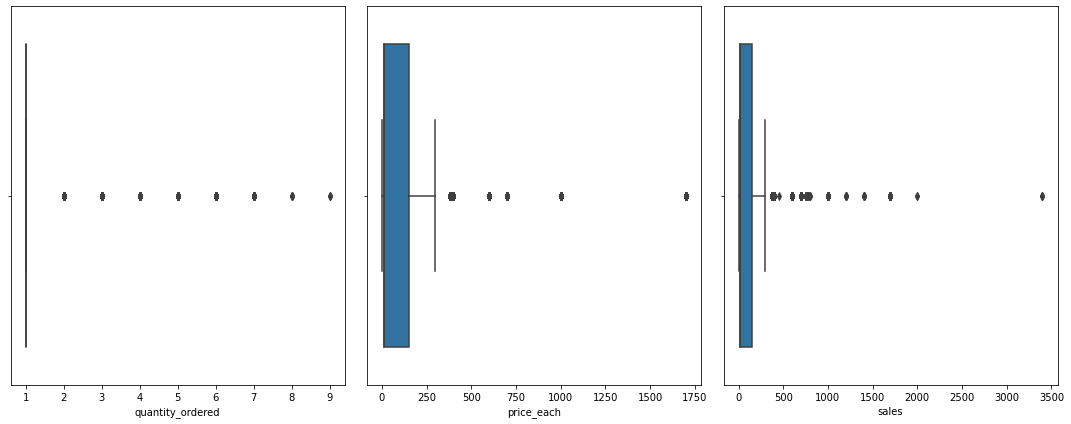

In [50]:
numeric_col = ['quantity_ordered', 'price_each', 'sales']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
axes = axes.flatten()

for i,col in enumerate(numeric_col):
    sns.boxplot(data=data, x=col, ax=axes[i])

fig.tight_layout()
plt.show()

#### Using z-scores

- We can define the values that are a couple of z-scores above or below the mean (or the max/min value).
- A z-score greater than a certain threshold (e.g., 2 or 3) could indicate an outlier.

In [62]:
df['price_each'].std()

332.8438383900525

In [64]:
# For price each column

upper_limit = df['price_each'].mean() + 2 * df['price_each'].std()
lower_limit = df['price_each'].mean() - 2 * df['price_each'].std()

print("Upper Limit: {}".format(upper_limit))
print("Lower Limit: {}".format(lower_limit))

Upper Limit: 850.2069322436295
Lower Limit: -481.1684213165805


C:\Users\chano\AppData\Local\Temp\ipykernel_6648\1078977953.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price_each'], ax=ax)


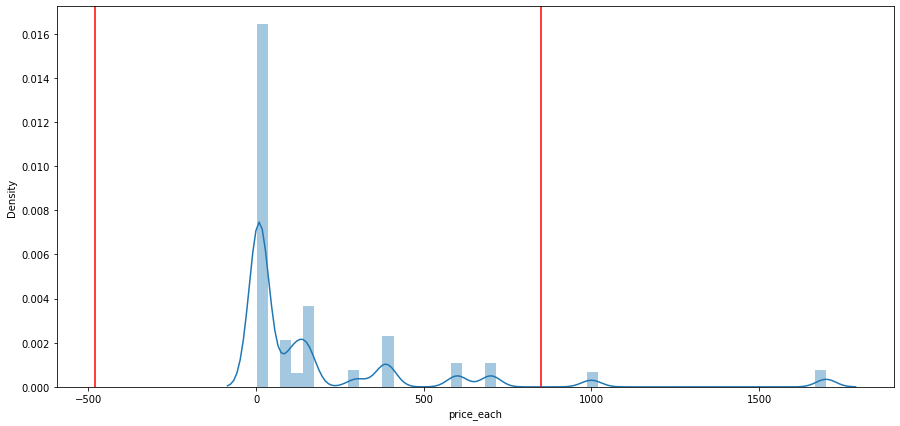

In [61]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(df['price_each'], ax=ax)
ax.axvline(lower_limit, color='red')
ax.axvline(upper_limit, color='red')

In [56]:
df['sales'].mean()

185.6119359563995

In [65]:
# For sales column

upper_limit_sales = data['sales'].mean() + 2 * data['sales'].std()
lower_limit_sales = data['sales'].mean() - 2 * data['sales'].std()

print("Upper Limit: {}".format(upper_limit_sales))
print("Lower Limit: {}".format(lower_limit_sales))

Upper Limit: 851.6761718623969
Lower Limit: -480.4522999495979


C:\Users\chano\AppData\Local\Temp\ipykernel_6648\3886735041.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['sales'], ax=ax)


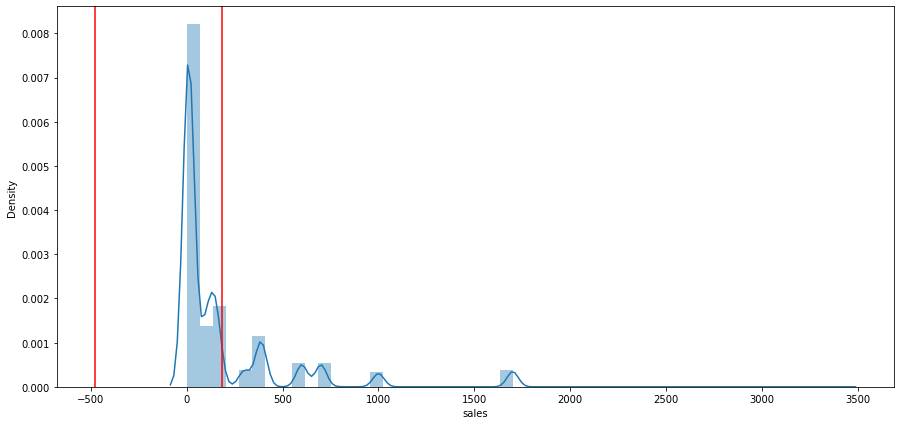

In [60]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(data['sales'], ax=ax)
ax.axvline(lower_limit_sales, color='red')
ax.axvline(upper_limit_sales, color='red')

### IQR

In [8]:
iqr = data['sales'].quantile(.75) - data['sales'].quantile(.25)

In [101]:
upper_limit = df['sales'].mean() + 1.5 * iqr
lower_limit = df['sales'].mean() - 1.5 * iqr

print("Upper Limit: {}".format(upper_limit))
print("Lower Limit: {}".format(lower_limit))

Upper Limit: 392.6869359563995
Lower Limit: -21.463064043600525


C:\Users\chano\AppData\Local\Temp\ipykernel_9912\484930125.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['sales'], ax=ax)


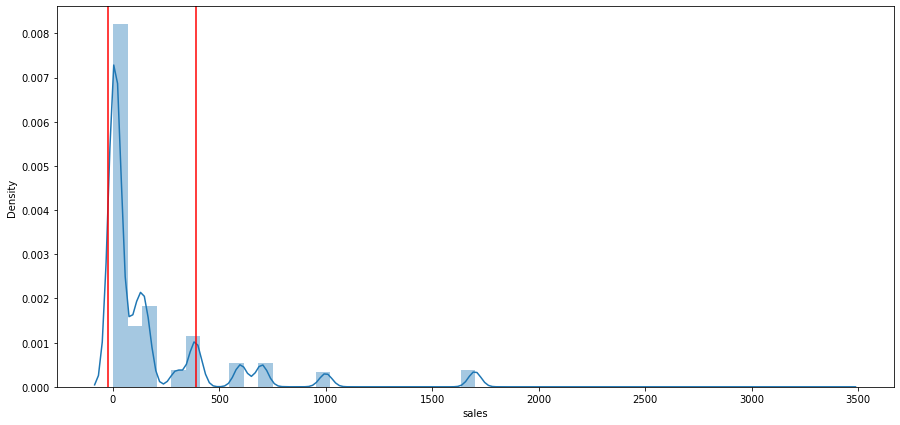

In [102]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(data['sales'], ax=ax)
ax.axvline(lower_limit, color='red')
ax.axvline(upper_limit, color='red')

In [103]:
upper_limit = data['price_each'].mean() + 1.5 * iqr
lower_limit = data['price_each'].mean() - 1.5 * iqr

print("Upper Limit: {}".format(upper_limit))
print("Lower Limit: {}".format(lower_limit))

Upper Limit: 391.59425546352446
Lower Limit: -22.555744536475572


C:\Users\chano\AppData\Local\Temp\ipykernel_9912\2340081323.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['price_each'], ax=ax)


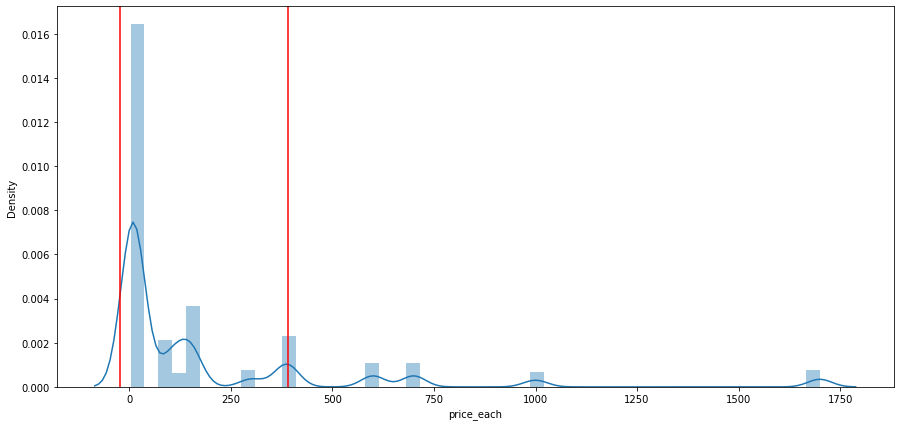

In [104]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(data['price_each'], ax=ax)
ax.axvline(lower_limit, color='red')
ax.axvline(upper_limit, color='red')

<AxesSubplot:xlabel='sales', ylabel='price_each'>

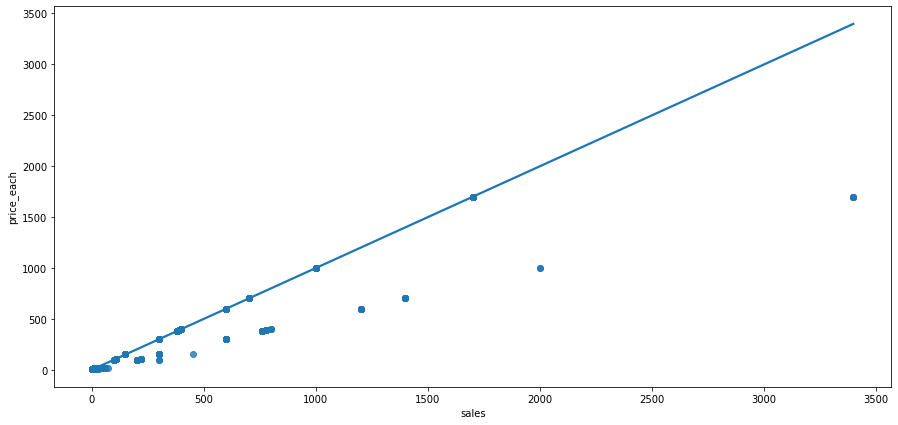

In [74]:
fig, ax = plt.subplots(figsize=(15,7))
sns.regplot(x='sales', y='price_each', data= df, ax=ax)

#### Insights:
- Figure above says the more accurate upper and lower limit is the IQR
- We will need to investigate what are these data that are being distibuted and the data above the upper limit.
- I will assume that it will make more sense if we investigate the product columns and the customer address

In [99]:
data_outside = data[data['price_each']>upper_limit]
product = data_outside.groupby(['product'])['quantity_ordered'].sum().sort_values(ascending=False).reset_index()
product

,product,quantity_ordered
0,iPhone,6847
1,Google Phone,5529
2,Macbook Pro Laptop,4725
3,ThinkPad Laptop,4128
4,LG Washing Machine,666
5,LG Dryer,646


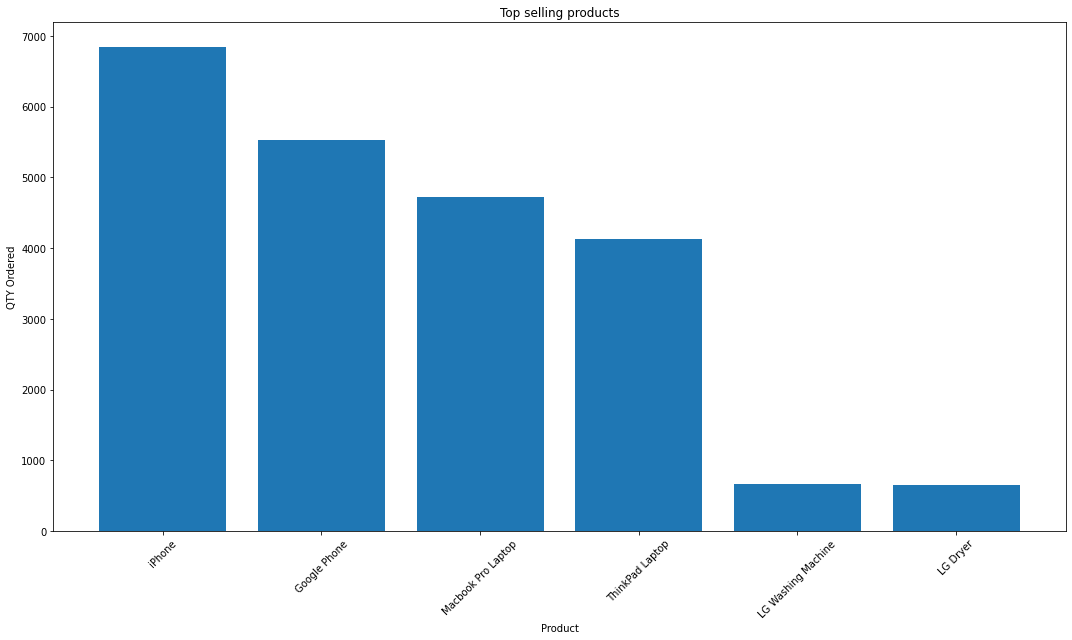

In [71]:
plt.figure(figsize=(15,9))
plt.bar(product['product'], product['quantity_ordered'])
plt.title('Top selling products')
plt.xlabel('Product')
plt.ylabel('QTY Ordered')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [100]:
data_inside = data[data['price_each'] < upper_limit]
products = data_inside.groupby(['product'])['quantity_ordered'].sum().sort_values(ascending=False).reset_index()
products

,product,quantity_ordered
0,AAA Batteries (4-pack),30986
1,AA Batteries (4-pack),27615
2,USB-C Charging Cable,23931
3,Lightning Charging Cable,23169
4,Wired Headphones,20524
5,Apple Airpods Headphones,15637
6,Bose SoundSport Headphones,13430
7,27in FHD Monitor,7541
8,27in 4K Gaming Monitor,6239
9,34in Ultrawide Monitor,6192


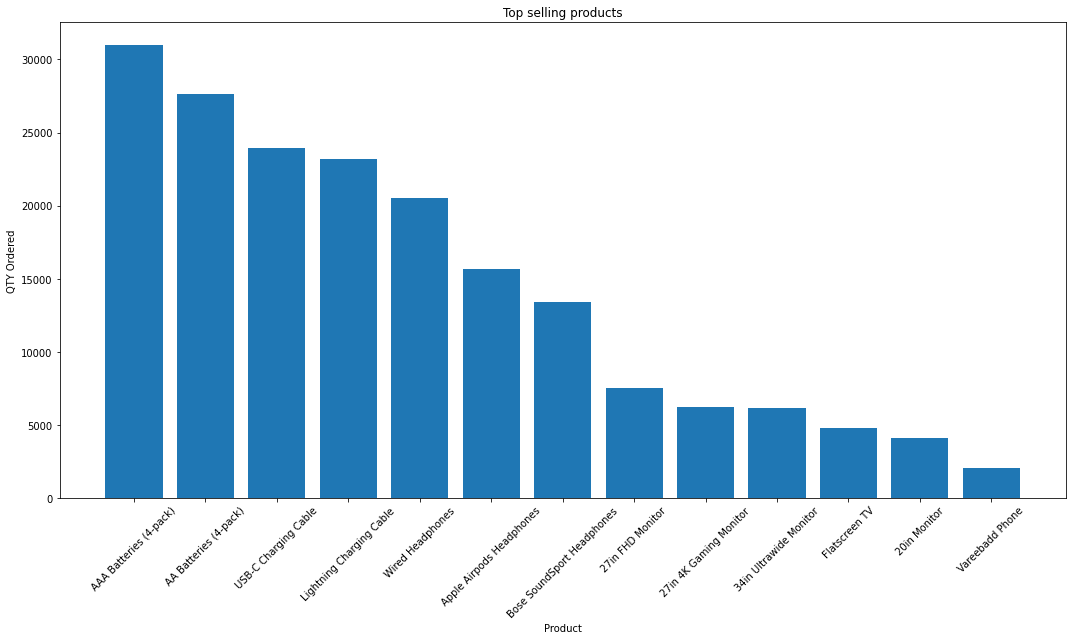

In [74]:
plt.figure(figsize=(15,9))
plt.bar(products['product'], products['quantity_ordered'])
plt.title('Top selling products')
plt.xlabel('Product')
plt.ylabel('QTY Ordered')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
data[data['product']=='AAA Batteries (4-pack)']['price_each'].unique()

array([2.99])

In [98]:
data[data['price_each'] == 1700]

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,sales,month,year
8,176565,Macbook Pro Laptop,1,1700.0,2019-04-24 10:38:00,"915 Willow St, San Francisco, CA 94016",1700.0,April,2019
84,176639,Macbook Pro Laptop,1,1700.0,2019-04-28 16:14:00,"853 Cedar St, San Francisco, CA 94016",1700.0,April,2019
88,176643,Macbook Pro Laptop,1,1700.0,2019-04-27 21:32:00,"373 Adams St, Boston, MA 02215",1700.0,April,2019
91,176646,Macbook Pro Laptop,1,1700.0,2019-04-22 07:14:00,"657 Adams St, Portland, OR 97035",1700.0,April,2019
134,176687,Macbook Pro Laptop,1,1700.0,2019-04-30 10:26:00,"121 Wilson St, Los Angeles, CA 90001",1700.0,April,2019
...,...,...,...,...,...,...,...,...,...
185357,259041,Macbook Pro Laptop,1,1700.0,2019-09-13 23:14:00,"220 Sunset St, New York City, NY 10001",1700.0,September,2019
185477,259157,Macbook Pro Laptop,1,1700.0,2019-09-12 05:01:00,"326 Forest St, Seattle, WA 98101",1700.0,September,2019
185624,259299,Macbook Pro Laptop,1,1700.0,2019-09-30 23:59:00,"240 Chestnut St, Los Angeles, CA 90001",1700.0,September,2019
185634,259308,Macbook Pro Laptop,1,1700.0,2019-09-26 19:16:00,"912 8th St, Boston, MA 02215",1700.0,September,2019


## Conclusion

The distribution skewed to the right because the product becomes expensive. It has no outliers. Inside the distribution the top most sold product is `AAA Batteries (4-pack)` with a `$30,986` order, and in outside the distribution the most sold product is `iPhone` with a `$6,847` order. The most distributed or sold product is the one who has a cheaper price.